In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [27]:
experiment = MIAExperiment(sampling_condition_dict_list = None)

In [13]:
base_model = model_utils.get_model(max_iter=500)
experiment.clf_only_on_test = copy.deepcopy(base_model)
experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=500, random_state=42)

In [51]:
sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
experiment.correct_indices = (sens_pred == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
experiment.incorrect_indices = ~experiment.correct_indices

In [6]:
experiment.original_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==0]
experiment.original_df = experiment.original_df.drop(['is_train'], axis=1)
experiment.aux_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
experiment.aux_df = experiment.aux_df.drop(['is_train'], axis=1)
experiment.y_column = experiment.ds.ds.meta['y_column']

In [24]:
experiment.original_df[['PINCP']].value_counts()

PINCP
0        25473
1         4527
Name: count, dtype: int64

In [20]:
experiment.original_df[['MAR']][experiment.correct_indices].value_counts()

MAR
0      6405
4      1253
2       694
1       407
3        75
Name: count, dtype: int64

In [29]:
experiment.indices_by_sensitive_value = {i: (1 == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_{i}']].to_numpy().ravel()) for i in [0, 1, 2]}

In [21]:
experiment = copy.deepcopy(old_experiment)

In [30]:
sample_indices = np.unique(
    np.concatenate([
        np.random.choice(np.where(experiment.indices_by_sensitive_value[0])[0], size=10000, replace=False),
        np.random.choice(np.where(experiment.indices_by_sensitive_value[1])[0], size=10000, replace=False),
        np.random.choice(np.where(experiment.indices_by_sensitive_value[2])[0], size=10000, replace=False)
    ])
)

old_experiment = copy.deepcopy(experiment)
experiment.X_test = experiment.X_test.iloc[sample_indices].copy().reset_index(drop=True)
experiment.y_te = experiment.y_te[sample_indices]
experiment.y_te_onehot = experiment.y_te_onehot[sample_indices]

In [31]:
base_model = model_utils.get_model(max_iter=500)
experiment.clf_only_on_test = copy.deepcopy(base_model)
experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=500, random_state=42)

In [55]:
experiment.original_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==0]
experiment.original_df = experiment.original_df.drop(['is_train'], axis=1).iloc[sample_indices].copy().reset_index(drop=True)
experiment.aux_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
experiment.aux_df = experiment.aux_df.drop(['is_train'], axis=1)
experiment.y_column = experiment.ds.ds.meta['y_column']

In [49]:
sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
sensitive_columns = [f'{experiment.ds.ds.meta["sensitive_column"]}_{sens_val}' for sens_val in experiment.ds.ds.meta["sensitive_values"]]
experiment.sens_ground_truth = experiment.X_test[sensitive_columns].idxmax(axis=1).str.split('_').str[1].to_numpy().astype(np.int).ravel()
experiment.correct_indices = (sens_pred == experiment.sens_ground_truth)
experiment.incorrect_indices = ~experiment.correct_indices
experiment.sensitive_column = experiment.ds.ds.meta["sensitive_column"]

In [44]:
from collections import Counter
Counter(sens_pred)

Counter({1.0: 8366, 2.0: 14396, 0.0: 7238})

In [34]:
experiment.confidence_array = get_confidence_array(experiment, experiment.X_test, experiment.y_te, experiment.clf_only_on_test)

In [51]:
experiment.correct_indices.mean()

0.3705333333333333

In [53]:
experiment.ds.ds.filenameroot = experiment.ds.ds.filenameroot + "_multi_valued_no_skew"

In [56]:
try:
    experiment.all_vuln_scores = np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy')
except:
    experiment.all_vuln_scores = np.array([get_vulnerability_score(experiment, experiment.X_test, experiment.y_te, experiment.original_df, index, k=4) for index in tqdm(experiment.X_test.index)])
    np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy', experiment.all_vuln_scores)
experiment.all_vuln_scores_rounded = np.round(experiment.all_vuln_scores)
experiment.vuln_accuracy = accuracy_score(experiment.correct_indices, experiment.all_vuln_scores_rounded)

100%|██████████| 30000/30000 [03:43<00:00, 134.08it/s]


In [57]:
experiment.vuln_accuracy

0.5427

In [58]:
X_test_w_vuln = experiment.X_test.copy()
# X_test_w_vuln[['vuln']] 
X_test_w_vuln['vuln'] = pd.Series(experiment.all_vuln_scores_rounded, index=X_test_w_vuln.index)

In [59]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_w_vuln.values).float(), torch.tensor(experiment.y_te_onehot).float())
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [40]:
import hashlib

def hash_tensor(tensor: torch.Tensor) -> int:
    # Convert tensor to bytes and hash it
    tensor_bytes = tensor.clone().cpu().detach().numpy().tobytes()
    return int(hashlib.md5(tensor_bytes).hexdigest(), 16) % (2**32)

In [60]:
class PortedMLPClassifier(nn.Module):
    def __init__(self, n_in_features=37, n_out_features=2):
        super(PortedMLPClassifier, self).__init__()
        layers = [
            nn.Linear(in_features=n_in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=n_out_features),
            nn.Softmax(dim=1)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)
    
    def predict_proba(self, x: torch.Tensor):
        return self.forward(x)
    
class MLPClassifierMutualInfoReg(nn.Module):
    def __init__(self, n_in_features=37, n_feat_dim=10, n_out_features=2):
        super(MLPClassifierMutualInfoReg, self).__init__()
        layers = [
            nn.Linear(in_features=n_in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=n_feat_dim),
            # nn.Softmax(dim=1)
        ]
        self.layers = nn.Sequential(*layers)
        self.k = n_feat_dim//2
        self.st_layer = nn.Linear(in_features=n_feat_dim, out_features=self.k*2)
        self.classifier = nn.Linear(in_features=self.k, out_features=n_out_features)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        
        statis = self.st_layer(x)
        mu, std = statis[:, :self.k], statis[:, self.k:]
        std = torch.functional.F.softplus(std-5)
        # torch.manual_seed(42)
        # seed = hash_tensor(x)
        # torch.manual_seed(seed)
        eps = torch.FloatTensor(std.size()).normal_().to(x.device)
        x = mu + eps * std
        x = self.classifier(x)
        x = self.softmax(x)
        return x, mu, std
    
    def predict_proba(self, x: torch.Tensor):
        return self.forward(x)[0]

def train_mir_classifier(model, train_loader, beta=0.1, selective_reg=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in tqdm(range(10)):
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            data, target = data.to('mps'), target.to('mps')
            output, mu, std = model(data[:, :-1])
            info_loss = - 0.5 * (1 + 2 * (std+1e-7).log() - mu.pow(2) - std.pow(2)).sum(dim=1)
            if selective_reg:
                info_loss = info_loss * data[:, -1]
            info_loss = info_loss.mean()
            loss = nn.BCELoss()(output, target) + beta * info_loss
            loss.backward()
            optimizer.step()

# test on test set
def test_mir(model, X_test, y_te_onehot):
    x_te = X_test.values
    dataset = torch.utils.data.TensorDataset(torch.tensor(x_te).float(), torch.tensor(y_te_onehot).float())
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=x_te.shape[0], shuffle=False)

    model.eval()
    y_pred = []
    y_true = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to('mps'), target.to('mps')
        output, _, _ = model(data)
        y_pred.append(output.cpu().detach().numpy())
        y_true.append(target.cpu().detach().numpy())

    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)

    return accuracy_score(y_true, y_pred)
    return(classification_report(y_true, y_pred))

In [61]:
betas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3]

model_zero_by_beta = {}

for beta in betas:
    try:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        model.load_state_dict(torch.load(f"{experiment.ds.ds.filenameroot}_mutual_info_reg_{beta}.pt"))
    except:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        train_mir_classifier(model, train_loader, beta=beta)
        torch.save(model.state_dict(), f"{experiment.ds.ds.filenameroot}_mutual_info_reg_{beta}.pt")
    
    model_zero_by_beta[beta] = model


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


In [62]:
betas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]

model_by_beta = {}

for beta in betas:
    try:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        model.load_state_dict(torch.load(f"{experiment.ds.ds.filenameroot}_mutual_info_reg_vuln_{beta}.pt"))
    except:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        train_mir_classifier(model, train_loader, beta=beta, selective_reg=True)
        torch.save(model.state_dict(), f"{experiment.ds.ds.filenameroot}_mutual_info_reg_vuln_{beta}.pt")
    
    model_by_beta[beta] = model


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


In [64]:
perf_dict = {}

metric_func = accuracy_score

for beta in model_zero_by_beta:
    model = model_zero_by_beta[beta]
    test_acc = test_mir(model, experiment.X_train, experiment.y_tr_onehot)
    sens_pred_CSMIA, _ = CSMIA_attack(model, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    csmia_acc = metric_func(experiment.sens_ground_truth, sens_pred_CSMIA)
    # sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_test, experiment.y_te, experiment.ds.ds.meta, indices=sample_indices)
    # lomia_acc = metric_func(experiment.sens_ground_truth, sens_pred_LOMIA)
    perf_dict[('zero', beta)] = {
        'test_acc': test_acc,
        'csmia_acc': csmia_acc,
        # 'lomia_acc': lomia_acc,
        'beta': beta,
        'type': 'regular'
    }

for beta in model_by_beta:
    model = model_by_beta[beta]
    test_acc = test_mir(model, experiment.X_train, experiment.y_tr_onehot)
    sens_pred_CSMIA, _ = CSMIA_attack(model, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    # sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_test, experiment.y_te, experiment.ds.ds.meta, indices=sample_indices)
    csmia_acc = metric_func(experiment.sens_ground_truth, sens_pred_CSMIA)
    # lomia_acc = metric_func(experiment.sens_ground_truth, experiment.sens_pred_LOMIA)
    perf_dict[('reg', beta)] = {
        'test_acc': test_acc,
        'csmia_acc': csmia_acc,
        # 'lomia_acc': lomia_acc,
        'beta': beta,
        'type': 'selective'
    }

  0%|          | 0/30000 [17:30<?, ?it/s]


In [65]:
perf_df = pd.DataFrame.from_dict(perf_dict, orient='index')

<Axes: xlabel='beta'>

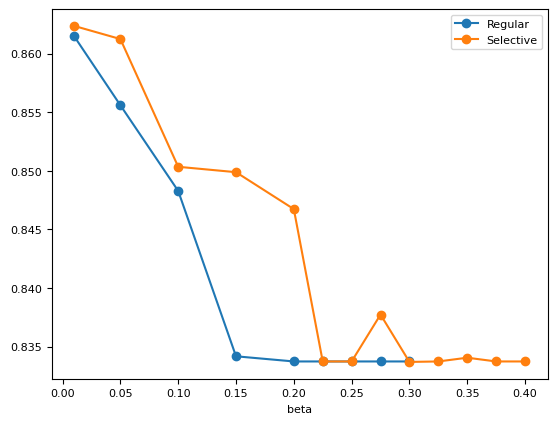

In [66]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='beta').plot(x='beta', y='test_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='beta').plot(x='beta', y='test_acc', ax=ax, label='Selective', marker='o')

<Axes: xlabel='beta'>

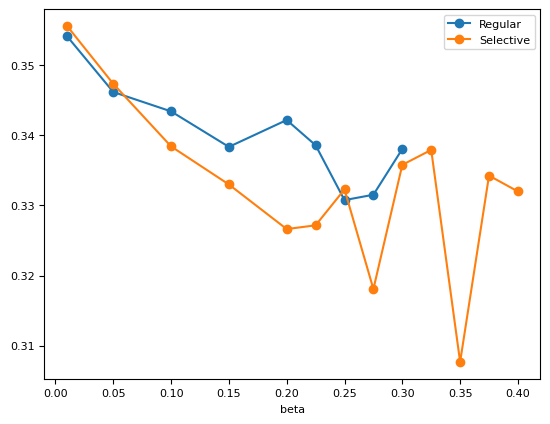

In [67]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='beta').plot(x='beta', y='csmia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='beta').plot(x='beta', y='csmia_acc', ax=ax, label='Selective', marker='o')

<Axes: xlabel='beta'>

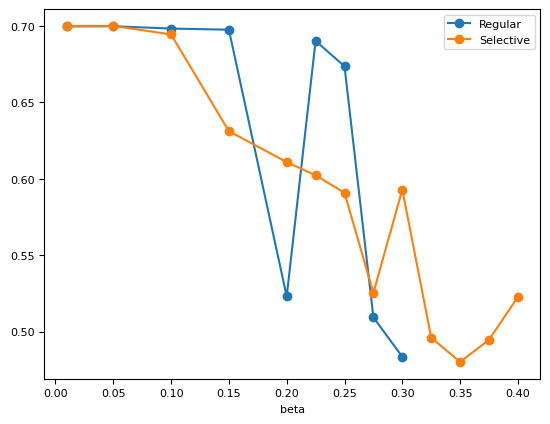

In [128]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='beta').plot(x='beta', y='lomia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='beta').plot(x='beta', y='lomia_acc', ax=ax, label='Selective', marker='o')

<Axes: xlabel='test_acc'>

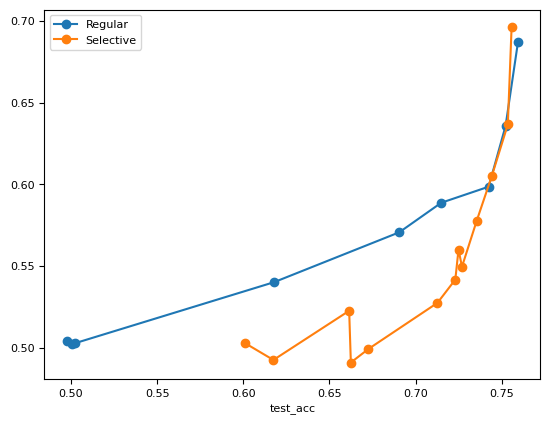

In [122]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc', ax=ax, label='Selective', marker='o')

<Axes: xlabel='test_acc'>

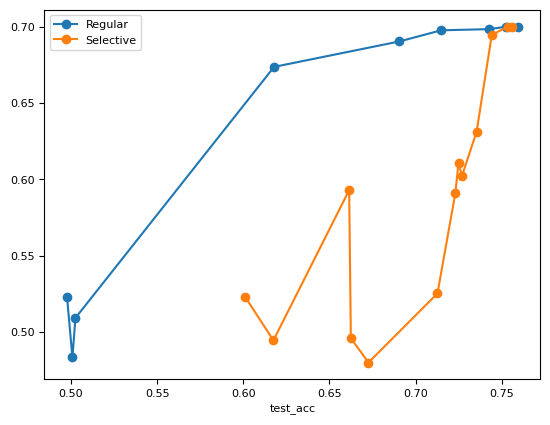

In [123]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='lomia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='test_acc').plot(x='test_acc', y='lomia_acc', ax=ax, label='Selective', marker='o')

<Axes: xlabel='test_acc'>

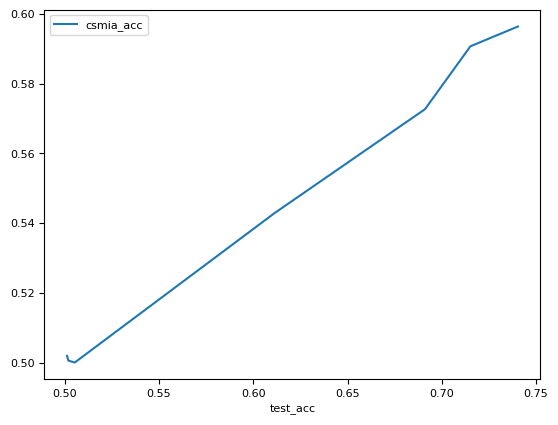

In [108]:
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc')

<Axes: xlabel='test_acc'>

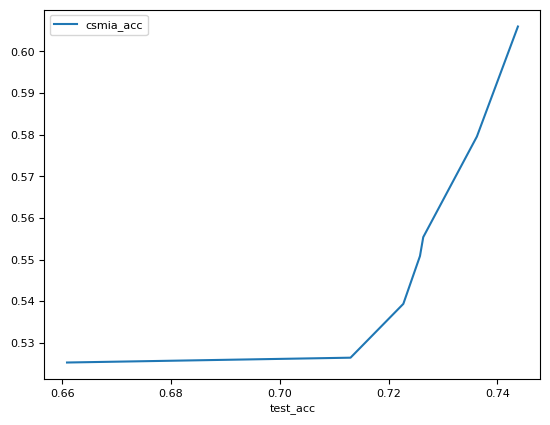

In [106]:
perf_df[['test_acc', 'csmia_acc', 'type']][perf_df['type']=='selective'].plot(x='test_acc', y='csmia_acc')

In [33]:
beta = 0.25
model_zero = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
optimizer = torch.optim.Adam(model_zero.parameters(), lr=0.001)

for epoch in tqdm(range(10)):
    for batch_idx, (data, target) in enumerate(train_loader):
        model_zero.train()
        optimizer.zero_grad()
        data, target = data.to('mps'), target.to('mps')
        output, mu, std = model_zero(data[:, :-1])
        info_loss = - 0.5 * (1 + 2 * (std+1e-7).log() - mu.pow(2) - std.pow(2)).sum(dim=1)
        info_loss = info_loss
        info_loss = info_loss.mean()
        loss = nn.BCELoss()(output, target) + beta * info_loss
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


In [48]:
beta = 0.25
try:
    model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
    model.load_state_dict(torch.load(f"mutual_info_reg_vuln_census_{beta}.pt"))
except:
    model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in tqdm(range(10)):
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            data, target = data.to('mps'), target.to('mps')
            output, mu, std = model(data[:, :-1])
            info_loss = - 0.5 * (1 + 2 * (std+1e-7).log() - mu.pow(2) - std.pow(2)).sum(dim=1)
            info_loss = info_loss * data[:, -1]
            info_loss = info_loss.mean()
            loss = nn.BCELoss()(output, target) + beta * info_loss
            loss.backward()
            optimizer.step()

# models[beta] = model

100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


In [14]:
data.shape

torch.Size([80, 108])

In [24]:
def CSMIA_attack_mir(model, X_test, y_test, meta, sensitive_columns=['marital_Married', 'marital_Single']):
    dfs = [X_test.copy() for _ in range(len(meta["sensitive_values"]))]
    if sensitive_columns is None:
        sensitive_columns = [f'{meta["sensitive_column"]}_{i}' for i in range(len(meta["sensitive_values"]))]
    for i in range(len(dfs)):
        dfs[i][sensitive_columns] = 0
        dfs[i][sensitive_columns[i]] = 1

        dfs[i] = torch.tensor(dfs[i].values).float().to('mps')
    
    y_confs = np.array([np.max(model.predict_proba(df).cpu().detach().numpy(), axis=1) for df in dfs]).T
    y_preds = [np.argmax(model.predict_proba(df).cpu().detach().numpy(), axis=1)==y_test.ravel() for df in dfs]
    y_preds = np.array(y_preds).T
    case_1_indices = (y_preds.sum(axis=1) == 1)
    case_2_indices = (y_preds.sum(axis=1) > 1)
    case_3_indices = (y_preds.sum(axis=1) == 0)

    eq_conf_indices = np.argwhere(y_confs[:, 0] == y_confs[:, 1]).ravel()
    # randomly add eps to one of the confidences for the records with equal confidences
    y_confs[eq_conf_indices, np.random.randint(0, 2, len(eq_conf_indices))] += 1e-6

    sens_pred = np.zeros(y_preds.shape[0])
    sens_pred[case_1_indices] = np.argmax(y_preds[case_1_indices], axis=1)
    sens_pred[case_2_indices] = np.argmax(y_confs[case_2_indices], axis=1)
    sens_pred[case_3_indices] = np.argmin(y_confs[case_3_indices], axis=1)
    return sens_pred, {1: case_1_indices, 2: case_2_indices, 3: case_3_indices}

In [25]:
def get_CSMIA_case_by_case_results_mir(clf, X_train, y_tr, ds, subgroup_col_name, metric='precision', sensitive_col_name='marital_Single'):
    if sensitive_col_name is None:
        sensitive_col_name = f'{ds.ds.meta["sensitive_column"]}_1'
        sens_pred, case_indices = CSMIA_attack_mir(clf, X_train, y_tr, ds.ds.meta, sensitive_columns=None)
    else:
        sens_pred, case_indices = CSMIA_attack_mir(clf, X_train, y_tr, ds.ds.meta)
    correct_indices = (sens_pred == X_train[[sensitive_col_name]].to_numpy().ravel())

    # subgroup_csmia_case_dict = {
    #     i: X_train.iloc[np.argwhere(case_indices[i]).ravel()][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
    # }

    subgroup_csmia_case_indices_by_subgroup_dict = {
        i: { j: np.intersect1d(np.argwhere(case_indices[i]).ravel(), np.argwhere(X_train[f'{subgroup_col_name}'].to_numpy().ravel() == j).ravel()) for j in [1, 0] } for i in range(1, 4)
    }

    subgroup_csmia_case_indices_by_subgroup_dict['All Cases'] = { j: np.argwhere(X_train[f'{subgroup_col_name}'].to_numpy().ravel() == j).ravel() for j in [1, 0] }

    def fun(metric):
        if metric.__name__ in ['precision_score', 'recall_score', 'f1_score']:
            return lambda x: round(100 * metric(x[0], x[1], pos_label=1), 4)
        else:
            return lambda x: round(100 * metric(x[0], x[1]), 4)
    
    def fun2(x):
        tp, fn, fp, tn = confusion_matrix(x[0], x[1]).ravel()
        return f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}"
    
    def false_positive_rate(x):
        tp, fn, fp, tn = confusion_matrix(x[0], x[1]).ravel()
        return round(100 * fp / (fp + tn), 4)

    eval_func = { 
        'precision': fun(precision_score),
        'recall': fun(recall_score),
        'f1': fun(f1_score),
        'accuracy': fun(accuracy_score),
        'fpr': false_positive_rate,
        # 'confusion_matrix': lambda x: f"TP: {confusion_matrix(x[0], x[1], labels=labels)[0, 0]}, FP: {confusion_matrix(x[0], x[1], labels=labels)[0, 1]}, FN: {confusion_matrix(x[0], x[1], labels=labels)[1, 0]}, TN: {confusion_matrix(x[0], x[1], labels=labels)[1, 1]}",
        'confusion_matrix': fun2,
        # 'mcc': fun(matthews_corrcoef),
        # 'gmean': fun(geometric_mean_score),
    }[metric]

    perf_dict = {
        i: { j: eval_func((X_train.loc[subgroup_csmia_case_indices_by_subgroup_dict[i][j], sensitive_col_name], sens_pred[subgroup_csmia_case_indices_by_subgroup_dict[i][j]])) for j in [1, 0] } for i in [1, 2, 3, 'All Cases']
    }

    temp_dict = {
        f'Case {i}': { j: f'{subgroup_csmia_case_indices_by_subgroup_dict[i][j].shape[0]} ({perf_dict[i][j]})' for j in [1, 0] } for i in [1, 2, 3, 'All Cases']
    }

    # subgroup_csmia_case_correct_dict = {
    #     i: X_train.iloc[np.intersect1d(np.argwhere(case_indices[i]).ravel(), np.argwhere(correct_indices).ravel())][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
    # }

    # temp_dict = {
    #     f'Case {i}': { j: f'{subgroup_csmia_case_dict[i][j]} ({round(100 * subgroup_csmia_case_correct_dict[i][j] / subgroup_csmia_case_dict[i][j], 2)})' for j in [1, 0] } for i in range(1, 4)
    # }
    # temp_dict['All Cases'] = { j: f'{subgroup_csmia_case_dict[1][j] + subgroup_csmia_case_dict[2][j] + subgroup_csmia_case_dict[3][j]} ({round(100 * (subgroup_csmia_case_correct_dict[1][j] + subgroup_csmia_case_correct_dict[2][j] + subgroup_csmia_case_correct_dict[3][j]) / (subgroup_csmia_case_dict[1][j] + subgroup_csmia_case_dict[2][j] + subgroup_csmia_case_dict[3][j]), 2)})' for j in [1, 0] }

    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    return temp_df

In [67]:
test_mir(model_zero, experiment.X_train, experiment.y_tr_onehot)

NameError: name 'model_zero' is not defined

In [81]:
test_mir(model, experiment.X_train, experiment.y_tr_onehot)

0.72104

In [25]:
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', sensitive_col_name=None)

,1,0,Overall
Case 1,4528 (70.0309),4312 (69.2022),69.6267
Case 2,17836 (68.2048),17694 (68.8312),68.5167
Case 3,2636 (63.7709),2994 (58.016),60.7105
Case All Cases,25000 (68.068),25000 (67.6),67.8340


In [26]:
get_CSMIA_case_by_case_results_mir(model, experiment.X_test, experiment.y_te, experiment.ds, 'SEX_1', metric='accuracy', sensitive_col_name=None)

,1,0
Case 1,4466 (66.7936),3819 (64.6242)
Case 2,15913 (67.5046),16017 (63.4888)
Case 3,4621 (63.2331),5164 (58.8691)
Case All Cases,25000 (66.588),25000 (62.708)


In [22]:
get_CSMIA_case_by_case_results(model, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', sensitive_col_name=None)

,1,0,Overall
Case 1,4466 (66.7936),3819 (64.6242),65.7936
Case 2,15913 (67.5046),16017 (63.4888),65.4901
Case 3,4621 (63.2331),5164 (58.8691),60.9300
Case All Cases,25000 (66.588),25000 (62.708),64.6480


In [35]:
get_CSMIA_case_by_case_results_mir(model_zero, experiment.X_test, experiment.y_te, experiment.ds, 'SEX_1', metric='accuracy', sensitive_col_name=None)

,1,0
Case 1,10065 (56.4034),10010 (55.6743)
Case 2,11282 (52.0652),11085 (52.6026)
Case 3,3653 (49.9589),3905 (49.6031)
Case All Cases,25000 (53.504),25000 (53.364)
